# Bitcoin Tweets Sentiment Analysis Prediction -- CNN-LSTM

In [1]:
# Data analysis and wrangling
import pandas as pd
import numpy as np
import os
import string
import csv

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
from wordcloud import WordCloud

# Sentiment prediction
import re
import nltk
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

from tensorflow.keras import backend, models, layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, Dropout, LSTM
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Using TensorFlow backend.


In [2]:
# Upload the processed clean tweets

df = pd.read_csv('cleaned_tweet_data_05312020.csv', 
                    header = 0, 
                    error_bad_lines=False,
                    engine='python',
                    usecols=[2,5])

df.head()

,clean_text,sentiment
0,goldman sachs hosting client call bitcoin gold...,neutral
1,ok president trump endorsing tommy,positive
2,bitcoin day nwhen btc first used commercial tr...,positive
3,great icle nif way could avoided know like min...,positive
4,bitcoin btc current price gbp,neutral


In [3]:
df.tail()

,clean_text,sentiment
2015,xrp xrpcommunity btc bitcoin eth ltc vet oh ye...,positive
2016,yes world global pandemic world going recessio...,neutral
2017,last days grayscale bitcoin trust bought bitco...,neutral
2018,pretty incredible imho nwe need creativity lik...,positive
2019,drop sachs nget sats,neutral


## Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2020 entries, 0 to 2019
Data columns (total 2 columns):
clean_text    2020 non-null object
sentiment     2020 non-null object
dtypes: object(2)
memory usage: 31.7+ KB


In [5]:
df.describe()

,clean_text,sentiment
count,2020,2020
unique,1391,3
top,tick tock less blocks,neutral
freq,36,964


In [6]:
tweets_count = df['sentiment'].value_counts()
tweets_count

neutral     964
positive    788
negative    268
Name: sentiment, dtype: int64

Text(0, 0.5, 'Total Counts')

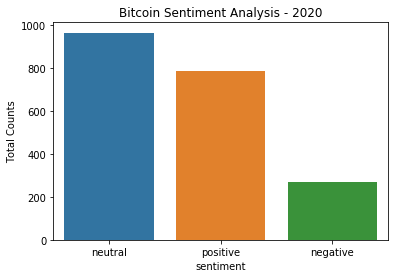

In [7]:
# Plot sentiment mood count
seaborn.countplot(x='sentiment', data=df)
plt.title('Bitcoin Sentiment Analysis - 2020')
plt.ylabel('Total Counts')

In [8]:
# add text length column

df['text_length'] = df['clean_text'].apply(len)

In [9]:
df.head()

,clean_text,sentiment,text_length
0,goldman sachs hosting client call bitcoin gold...,neutral,60
1,ok president trump endorsing tommy,positive,34
2,bitcoin day nwhen btc first used commercial tr...,positive,87
3,great icle nif way could avoided know like min...,positive,68
4,bitcoin btc current price gbp,neutral,29


In [10]:
df.tail()

,clean_text,sentiment,text_length
2015,xrp xrpcommunity btc bitcoin eth ltc vet oh ye...,positive,96
2016,yes world global pandemic world going recessio...,neutral,56
2017,last days grayscale bitcoin trust bought bitco...,neutral,70
2018,pretty incredible imho nwe need creativity lik...,positive,68
2019,drop sachs nget sats,neutral,20


In [11]:
df['text_length'].describe()

count    2020.000000
mean       61.235149
std        27.054467
min         4.000000
25%        39.000000
50%        66.500000
75%        83.000000
max       117.000000
Name: text_length, dtype: float64

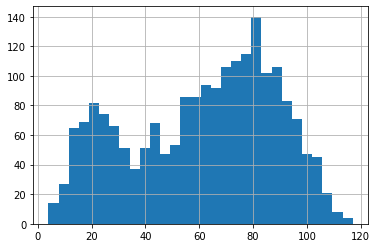

In [12]:
df['text_length'].hist(bins=30)

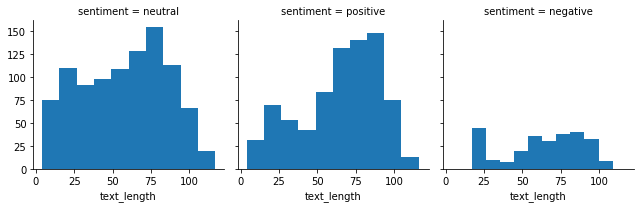

In [13]:
plot = seaborn.FacetGrid(df,col='sentiment')
plot.map(plt.hist,'text_length')

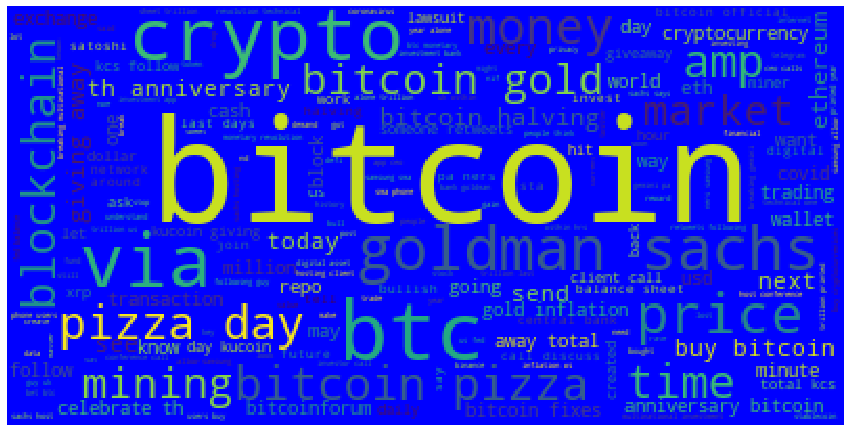

In [14]:
# visualization using wordcloud for the Neutral tweets

tweets_neutral = df[df['sentiment']=='neutral']
words = ' '.join(tweets_neutral['clean_text'])

wordcloud = WordCloud(background_color='blue').generate(words)

plt.figure(1,figsize=(15, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

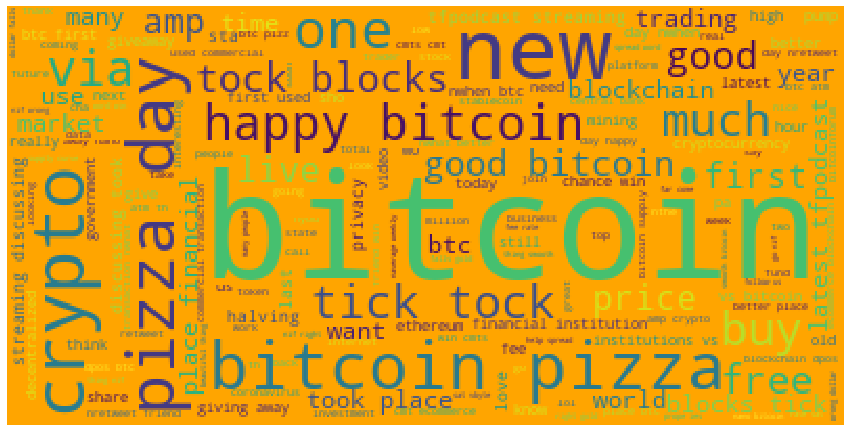

In [15]:
# visualization using wordcloud for the Positive tweets

tweets_positive = df[df['sentiment']=='positive']
words = ' '.join(tweets_positive['clean_text'])

wordcloud = WordCloud(background_color='orange').generate(words)

plt.figure(1,figsize=(15, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

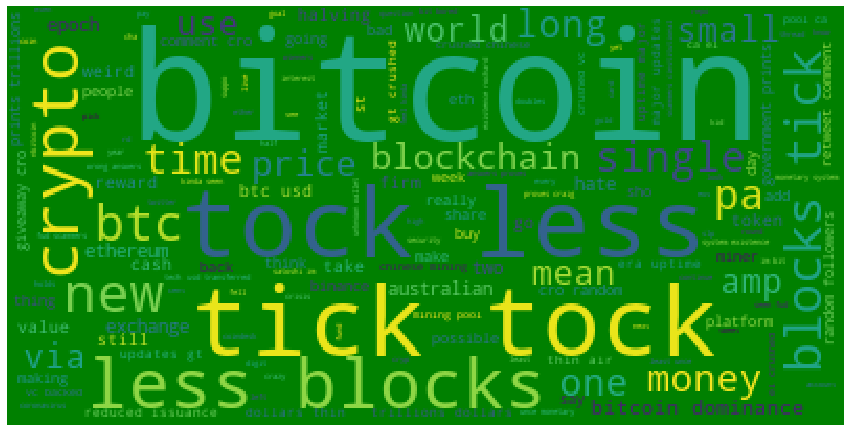

In [16]:
# visualization using wordcloud for the Negative tweets

tweets_negative = df[df['sentiment']=='negative']
words = ' '.join(tweets_negative['clean_text'])

wordcloud = WordCloud(background_color='green').generate(words)

plt.figure(1,figsize=(15, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

##  Training and Testing sets

In [17]:
# Encode Categorical Variable for Deep Learning
# Apply get_dummies

x = df['clean_text']
y = pd.get_dummies(df['sentiment']).values
num_classes = df['sentiment'].nunique()

In [18]:
# fix random seed for reproducibility
np.random.seed(42)

# Split into 80% train and 20% test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.20,
                                                    stratify=y,
                                                    random_state=42)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1616,) (404,) (1616, 3) (404, 3)


### Tokenize Text

In [19]:
# Tokenize Text

# Define max number of words in dictionary
max_features = 20000
tokenizer = Tokenizer(num_words=max_features, lower=True)
tokenizer.fit_on_texts(list(x_train))

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

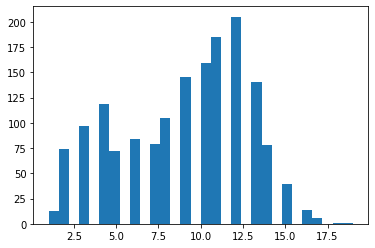

In [20]:
totalNumWords = [len(feature) for feature in x_train]
plt.hist(totalNumWords,bins = 30)
plt.show()

In [21]:
# Based on the plot histogram, setting feature maxWords
maxWords = 20

x_train = sequence.pad_sequences(x_train, maxlen=maxWords)
x_test = sequence.pad_sequences(x_test, maxlen=maxWords)

print(x_train.shape,x_test.shape)

(1616, 20) (404, 20)


## Model -- CNN Long Short-Term Memory Network (CNN LSTM)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 300)           6000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 20, 32)            28832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 32)            3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 32)             0         
_________________________________________________________________
lstm (LSTM)          

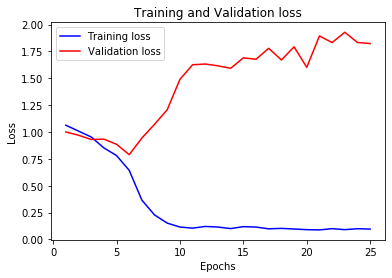

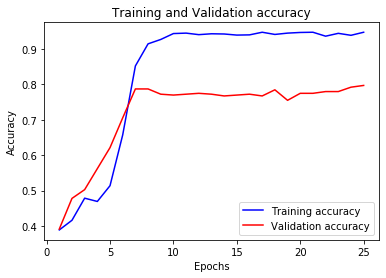

404/404 [==============================] - 0s 128us/sample - loss: 1.8239 - acc: 0.7970
['loss', 'acc']
[1.8238952685110639, 0.7970297]


In [22]:
# Build a CNN-LSTM Model

backend.clear_session()

embedding_size = 300
epoch = 25
batch_size = 64

model = models.Sequential()
model.add(Embedding(max_features, embedding_size, input_length=x_train.shape[1])) 
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(96, dropout=0.15, recurrent_dropout=0.15))

model.add(Dense(num_classes * 4, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes * 2, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])
print(model.summary())


# Train the model
history = model.fit(x_train,
                    y_train,
                    epochs = epoch,
                    batch_size = batch_size,
                    validation_data=(x_test, y_test),
                    verbose = 1)


history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(history_dict['acc']) + 1)

hist = pd.DataFrame(history.history)
print(hist.head())

plt.plot(epochs, loss_values, 'b', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'r', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'r', label = 'Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

results = model.evaluate(x_test, y_test)
print(model.metrics_names)
print(results)

## Model Prediction/Evaluation

In [23]:
# Reference link: https://stackoverflow.com/questions/44189119/how-to-plot-confusion-matrix-correctly

# Evaluate model with Test set

def model_evaluation(): 
    # predict class with test set
    y_pred_test =  model.predict_classes(x_test, batch_size=batch_size, verbose=0)
    print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test,axis=1),y_pred_test)*100))
    
    #classification report
    print('\n')
    print(classification_report(np.argmax(y_test,axis=1), y_pred_test))

    #confusion matrix
    confmatrix = confusion_matrix(np.argmax(y_test,axis=1), y_pred_test)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmatrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmatrix.shape[0]):
        for j in range(confmatrix.shape[1]):
            ax.text(x=j, y=i, s=confmatrix[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

Accuracy:	79.7%


              precision    recall  f1-score   support

           0       0.83      0.55      0.66        53
           1       0.79      0.85      0.82       193
           2       0.80      0.81      0.80       158

    accuracy                           0.80       404
   macro avg       0.81      0.74      0.76       404
weighted avg       0.80      0.80      0.79       404

None


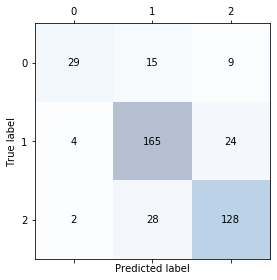

In [24]:
print(model_evaluation())